In [ ]:
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
import glob

from analysis_utils import parse_json, plot_annotations, count_in_polygons, parse_prediction_json, evaluate_detections, assign_majority_environment

TRAIN_ANNOTATIONS = pathlib.Path("../data/analysis/train_images/train_annotations.json")
TEST_ANNOTATIONS = pathlib.Path("../data/analysis/test_images/test_annotations.json")
PATH_PREDICTIONS= glob.glob("../data/analysis/test_images/test_predictions/*.json")

TRAIN_IMAGES = list(pathlib.Path("../data/analysis/train_images/").glob(pattern="*.JPG"))
TEST_IMAGES = list(pathlib.Path("../data/analysis/test_images/").glob(pattern="*.JPG"))

In [232]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# ANALYZE THE TRAINING AND TEST SET

In [3]:
train = parse_json(TRAIN_ANNOTATIONS)
test = parse_json(TEST_ANNOTATIONS)

FileNotFoundError: [Errno 2] No such file or directory: '../analysis/train_images/train_annotations.json'

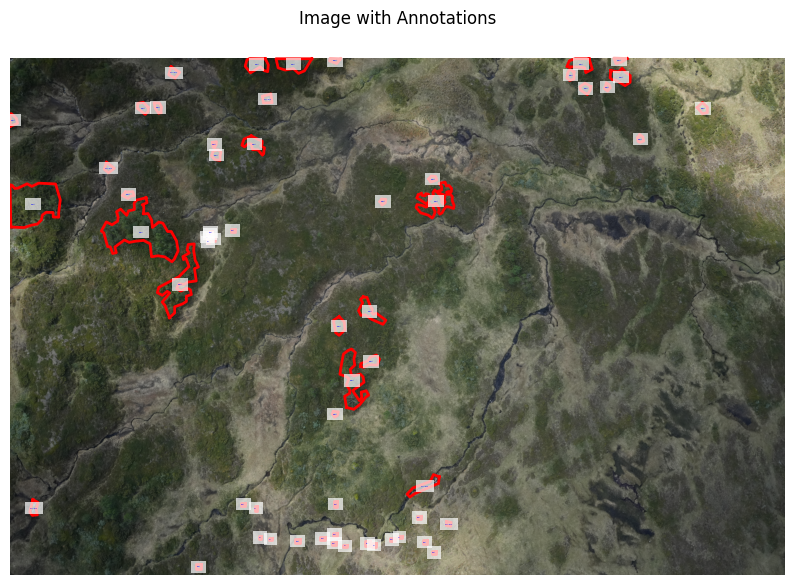

In [402]:
plot_annotations(TRAIN_IMAGES[1], train)

In [403]:
count_train = count_in_polygons(train)
count_test = count_in_polygons(test)

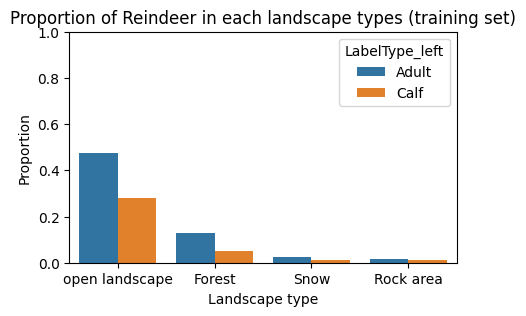

In [404]:
df_agg = count_train.groupby(['polygon_label', 'LabelType_left'])['count'].sum().reset_index()

df_agg['prop'] = df_agg['count'].transform(lambda x: x / x.sum())
max_prop = df_agg.groupby("polygon_label")["prop"].max().sort_values(ascending=False)
order = max_prop.index.tolist()

plt.figure(figsize=(5, 3))
sns.barplot(data=df_agg, x='polygon_label', y='prop', hue='LabelType_left', order=order)
plt.ylabel('Proportion')
plt.xlabel('Landscape type')
plt.title('Proportion of Reindeer in each landscape types (training set)')
plt.ylim(0, 1)
plt.show()

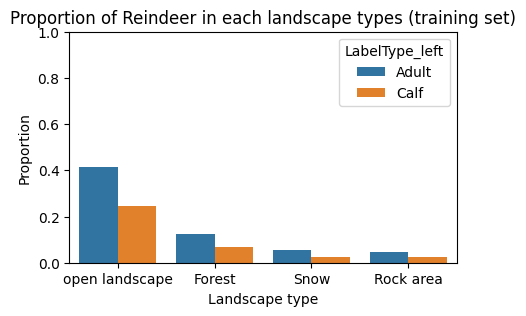

In [445]:
df_agg = count_test.groupby(['polygon_label', 'LabelType_left'])['count'].sum().reset_index()

df_agg['prop'] = df_agg['count'].transform(lambda x: x / x.sum())
max_prop = df_agg.groupby("polygon_label")["prop"].max().sort_values(ascending=False)
order = max_prop.index.tolist()

plt.figure(figsize=(5, 3))
sns.barplot(data=df_agg, x='polygon_label', y='prop', hue='LabelType_left', order=order)
plt.ylabel('Proportion')
plt.xlabel('Landscape type')
plt.title('Proportion of Reindeer in each landscape types (training set)')
plt.ylim(0, 1)
plt.show()

# ANALYZE THE MODEL RESULTS

In [406]:
list_gdf = []

for json_path in PATH_PREDICTIONS:
    df = parse_prediction_json(json_path)
    list_gdf.append(df)

preds = pd.concat(list_gdf)
preds = gpd.GeoDataFrame(preds, geometry=preds["geometry"])

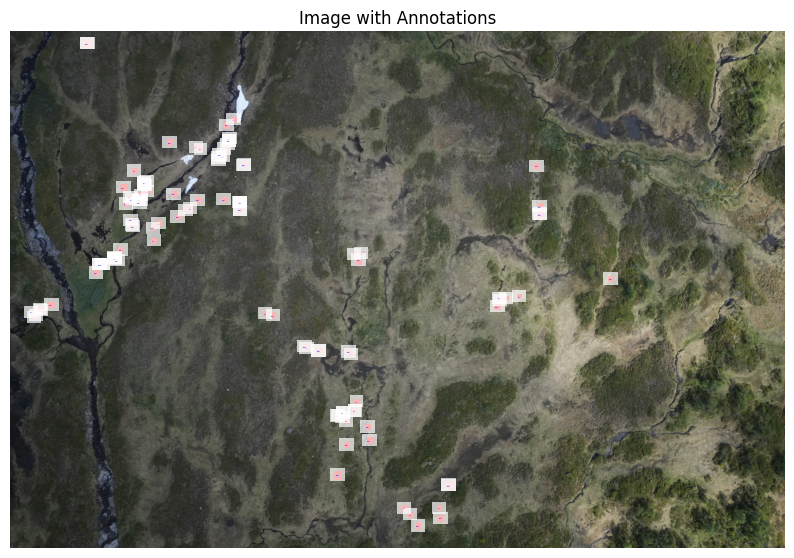

In [ ]:
img = Image.open("analysis/test_images/DSC00949.JPG")
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(img, origin="upper")

gdf = preds[preds["ImageID"] == "DSC00949"]

for idx, row in gdf.iterrows():
    geom = row["geometry"]
    label = row["LabelType"]
    if geom.is_empty:
        continue
    if geom.geom_type == "Polygon":
        x, y = geom.exterior.xy
        ax.plot(x, y, color="red", linewidth=2)
        centroid = geom.centroid
        ax.text(centroid.x, centroid.y, label, fontsize=1, color="blue",
                ha="center", va="center", bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

ax.set_title("Image with Annotations")
plt.axis("off")
plt.show()

In [466]:
test_reindeer_only = test[test["annotation_type"] == "bbox"]
test_landscape = test[test["annotation_type"] == "polygon"]
test_landscape["landtype"] = test_landscape["LabelType"]
test_landscape.drop("LabelType", axis=1, inplace=True)

/home/benjamin.cretois/Code/reindeerdrone/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_351584/557952945.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_landscape.drop("LabelType", axis=1, inplace=True)


In [ ]:
def assign_majority_environment(reindeer_gdf, landscape_gdf):
    
    assigned_list = []

    for image_id in reindeer_gdf['ImageID'].unique():
        reindeer_img = reindeer_gdf[reindeer_gdf['ImageID'] == image_id].copy()
        landscape_img = landscape_gdf[landscape_gdf['ImageID'] == image_id].copy()

        assigned_landtypes = []
        for idx, row in reindeer_img.iterrows():
            bbox = row.geometry
            candidate_landscapes = landscape_img[landscape_img.intersects(bbox)]

            if candidate_landscapes.empty:
                assigned_landtypes.append("Open Landscape")
                continue

            candidate_landscapes = candidate_landscapes.copy()  
            candidate_landscapes['intersection_area'] = candidate_landscapes.geometry.apply(lambda poly: bbox.intersection(poly).area)
            
            bbox_area = bbox.area
            candidate_landscapes['overlap_pct'] = candidate_landscapes['intersection_area'] / bbox_area
            
            best_candidate = candidate_landscapes.sort_values('intersection_area', ascending=False).iloc[0]
            assigned_landtypes.append(best_candidate['landtype'])
        
        reindeer_img['landtype'] = assigned_landtypes
        assigned_list.append(reindeer_img)

    return pd.concat(assigned_list, ignore_index=True)

In [487]:
preds_overlay = assign_majority_environment(preds, test_landscape)
gt_overlay = assign_majority_environment(test_reindeer_only, test_landscape)

In [523]:
## MODEL CONFIDENCE WITH FILTER
preds_overlay_filtered = preds_overlay[preds_overlay["score"] > 0.7]
tp, fp, fn = evaluate_detections(preds_overlay_filtered, gt_overlay)

In [ ]:
## MODEL CONFIDENCE WITH FILTER
preds_overlay_filtered = preds_overlay[preds_overlay["score"] > 0.7]
tp, fp, fn = evaluate_detections(preds_overlay_filtered, gt_overlay)

In [536]:
precision = len(tp) / (len(tp) + len(fp))
recall = len(tp) / (len(tp) + len(fn))
print(f"OVERALL PRECISION: {precision}, OVERALL RECALL: {recall}")

OVERALL PRECISION: 0.6596119929453262, OVERALL RECALL: 0.6977611940298507


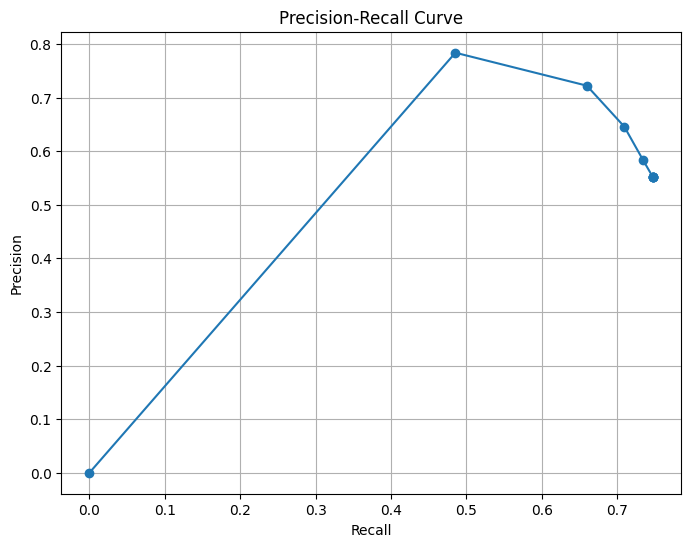

In [537]:
# Define a range of thresholds (for example, 50 thresholds from 0 to 1)
import numpy as np
thresholds = np.linspace(0, 1, 10)
precisions = []
recalls = []

for t in thresholds:
    # Filter predictions by threshold
    preds_filtered = preds_overlay[preds_overlay["score"] > t]
    # Evaluate detections: evaluate_detections returns lists for TP, FP, FN
    tp, fp, fn = evaluate_detections(preds_filtered, gt_overlay)
    
    # Compute precision and recall. Use a check to avoid division by zero.
    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) > 0 else 0
    recall = len(tp) / (len(tp) + len(fn)) if (len(tp) + len(fn)) > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='o', linestyle='-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [505]:
tp_df = tp.groupby(["LabelType", "landtype"]).size().reset_index(name='count_tp')
fp_df = fp.groupby(["LabelType", "landtype"]).size().reset_index(name='count_fp')
fn_df = fn.groupby(["LabelType", "landtype"]).size().reset_index(name='count_fn')


In [515]:
tp_fp = pd.merge(tp_df, fp_df)
all = pd.merge(tp_fp, fn_df)

In [516]:
all

,LabelType,landtype,count_tp,count_fp,count_fn
0,Adult,Forest,44,24,21
1,Adult,Open Landscape,204,55,27
2,Adult,Rock area,20,37,6
3,Adult,Snow,22,14,5
4,Calf,Forest,18,17,17
5,Calf,Open Landscape,64,41,65
6,Calf,Rock area,2,5,10


In [520]:
all["acc"] = all["count_tp"] / (all["count_tp"] + all["count_fp"]) 
all["recall"] = all["count_tp"] / (all["count_tp"] + all["count_fn"]) 

In [533]:
all # Model doesn't predict any calf in snow?????
# No bounding box in calf detection, so nothing to overlay with

,LabelType,landtype,count_tp,count_fp,count_fn,acc,recall
0,Adult,Forest,44,24,21,0.647059,0.676923
1,Adult,Open Landscape,204,55,27,0.787645,0.883117
2,Adult,Rock area,20,37,6,0.350877,0.769231
3,Adult,Snow,22,14,5,0.611111,0.814815
4,Calf,Forest,18,17,17,0.514286,0.514286
5,Calf,Open Landscape,64,41,65,0.609524,0.496124
6,Calf,Rock area,2,5,10,0.285714,0.166667


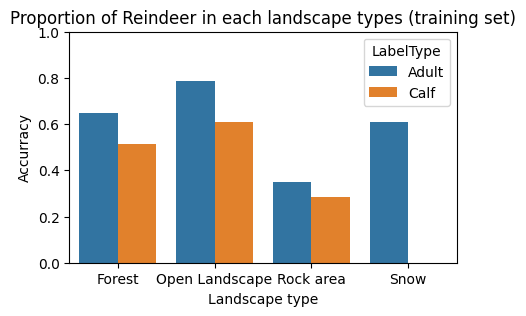

In [538]:
plt.figure(figsize=(5, 3))
sns.barplot(data=all, x='landtype', y='acc', hue='LabelType')
plt.ylabel('Accurracy')
plt.xlabel('Landscape type')
plt.title('Proportion of Reindeer in each landscape types (training set)')
plt.ylim(0, 1)
plt.show()